# 6.8.4 Challenge: Analyzing and predicting sentiment from Amazon Reviews
Challenge Context: we'd like to determine if we can predict whether a review is positive or negative based on the language in the review.

We're going to tackle this problem with Spark, so you'll need to apply the principles you've learned thus far in the context of Spark.

In [1]:
# Imports
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import Tokenizer, Word2Vec

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics


from pyspark.sql.functions import isnan, when, count, col

import matplotlib.pyplot as plt
import numpy as np
import functools
%matplotlib inline

In [2]:
# Setting Constants
JSON_PATH = "/home/ds/notebooks/reviews_Sports_and_Outdoors_5.json"
APP_NAME = "Amazon Sports Review Sentiments"
SPARK_URL = "local[*]"
RANDOM_SEED = 42
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

Now we're ready to connect to the Spark server.

In [3]:
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sqlContext = SQLContext(spark)
df = sqlContext.read.json(JSON_PATH)

And check that our dataframe matches the Amazon site.

In [4]:
# Confirm dataframe shape
print('Dataset shape is {} rows by {} columns.'.format(df.count(), len(df.columns)))

Dataset shape is 296337 rows by 9 columns.


Great, that matches.  Now let's check the columns.

In [5]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



Now let's inspect the overall ratings counts.

In [6]:
df.groupBy('overall').count().sort('overall').show()

+-------+------+
|overall| count|
+-------+------+
|    1.0|  9045|
|    2.0| 10204|
|    3.0| 24071|
|    4.0| 64809|
|    5.0|188208|
+-------+------+



Now, let's re-code all ratings 3 and under as a negative rating, and over 3 as a positive rating.

In [7]:
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())
df = df.withColumn('overall_recode', udf(df.overall))

Alright, now we have all of the reviews re-coded, let's check out the distribution of reviews.

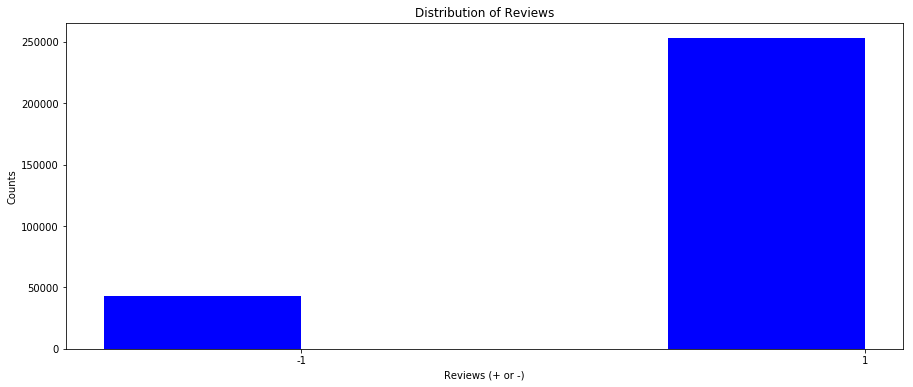

In [8]:
plt.figure(figsize = (15,6))

statuses = df.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]

ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='b')

plt.xlabel('Reviews (+ or -)')
plt.ylabel('Counts')
plt.title('Distribution of Reviews')
plt.xticks(ind + width/2., categories)
plt.show()


This looks very unbalanced.  I will undersample the positive reviews to the level of the  balance the categories out.

In [9]:
posDf = df.filter('overall_recode=1')
negDf = df.filter('overall_recode=-1')
sampleRatio = negDf.count() / df.count()
posSampleDf = posDf.sample(False, sampleRatio)

Now, we'll combine the positive and negative reviews together

In [23]:
negDf.unionAll(posSampleDf)

DataFrame[asin: string, helpful: array<bigint>, overall: double, reviewText: string, reviewTime: string, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint, overall_recode: int]

We are now ready to turn the text of the review into tokens and then into vectors using Tf-idf vectorizers.

In [10]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized_text").transform(negDf)

hashingTF = HashingTF(inputCol='tokenized_text', outputCol='rawFeatures', numFeatures=500)
featurizedData = hashingTF.transform(tokenizer)

In [11]:
idf = IDF(inputCol='rawFeatures', outputCol='features')
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select('overall_recode', 'features').show(5)

+--------------+--------------------+
|overall_recode|            features|
+--------------+--------------------+
|            -1|(500,[26,27,57,64...|
|            -1|(500,[5,7,35,36,8...|
|            -1|(500,[18,25,34,40...|
|            -1|(500,[12,18,34,36...|
|            -1|(500,[15,33,36,63...|
+--------------+--------------------+
only showing top 5 rows



Great, now let's check the schema to make sure the features are in there.

In [12]:
rescaledData.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- overall_recode: integer (nullable = true)
 |-- tokenized_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



And lets see if we can check the features versus the recode.

In [13]:
rescaledData.select('overall_recode', 'reviewText', 'tokenized_text', 'features').show(10)

+--------------+--------------------+--------------------+--------------------+
|overall_recode|          reviewText|      tokenized_text|            features|
+--------------+--------------------+--------------------+--------------------+
|            -1|It's cheaply made...|[it's, cheaply, m...|(500,[26,27,57,64...|
|            -1|So it worked well...|[so, it, worked, ...|(500,[5,7,35,36,8...|
|            -1|I have several di...|[i, have, several...|(500,[18,25,34,40...|
|            -1|The red band(heav...|[the, red, band(h...|(500,[12,18,34,36...|
|            -1|As most exercise ...|[as, most, exerci...|(500,[15,33,36,63...|
|            -1|Bought this for m...|[bought, this, fo...|(500,[9,10,18,21,...|
|            -1|I have had these ...|[i, have, had, th...|(500,[8,18,30,34,...|
|            -1|I have not even b...|[i, have, not, ev...|(500,[18,20,36,37...|
|            -1|I wish I would ha...|[i, wish, i, woul...|(500,[4,12,15,18,...|
|            -1|I bought these to...|[i,

Looks good.  We're ready to create the pipeline and train the model to predict if a review will be positive or negative.

In [14]:
labelIndexer = StringIndexer(inputCol='overall_recode', outputCol='indexedLabel').fit(rescaledData)

featureIndexer = VectorIndexer(inputCol='features', outputCol='indexedFeatures', maxCategories=4).fit(rescaledData)

(trainingData, testData) = rescaledData.randomSplit([TRAINING_DATA_RATIO, 1-TRAINING_DATA_RATIO])

rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures', numTrees=RF_NUM_TREES)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [15]:
model = pipeline.fit(trainingData)
predictions = model.transform(testData)

And finally, let's check the accuracy of this model. 

In [16]:
evaluator = MulticlassClassificationEvaluator(
    labelCol='indexedLabel', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print('Test Error = {}\nAccuracy = {}'.format(1.0 - accuracy, accuracy))

Test Error = 0.0
Accuracy = 1.0


Wow, 100% accuracy on the test set!?! Let's check the cross validation.

After seeing that the CrossValidator didn't work, I tried the following to make the test data into a usable form for it, both shown below.

In [30]:
testParamMap = testData.extractParamMap()
testParamMap

testDataMap = []
for row in testData:
    testDataMap.append([testData['features'], testData['overall_recode']])

I got this code from [this StackOverflow post](https://stackoverflow.com/questions/32769573/how-to-cross-validate-randomforest-model) for cross validating in spark.  

In [31]:
from pyspark.ml.tuning import CrossValidator

numFolds = 5

crossval = CrossValidator(
    estimator=pipeline,
    evaluator=evaluator,
    numFolds=numFolds)

model = crossval.fit(testDataMap)

print('Test Accuracy with 5-fold Cross-Validation: {} (+/- {})'.format(model.mean(), model.std()*2))

KeyError: Param(parent='CrossValidator_40a58748a92082b7045f', name='estimatorParamMaps', doc='estimator param maps')

This isn't working and I'm unsure of how to fix this.